**Thank You for reading this notebook!!**

**If you find this notebook useful or you just like it, please Upvote it as it would really mean a lot to me and it would keep me motivated to update this notebook regularly.**

**If you use any part of this notebook, please mention a link in your notebook, it would be much appreciated.**

**And if you have any question, or find out something isn't right please comment below.**

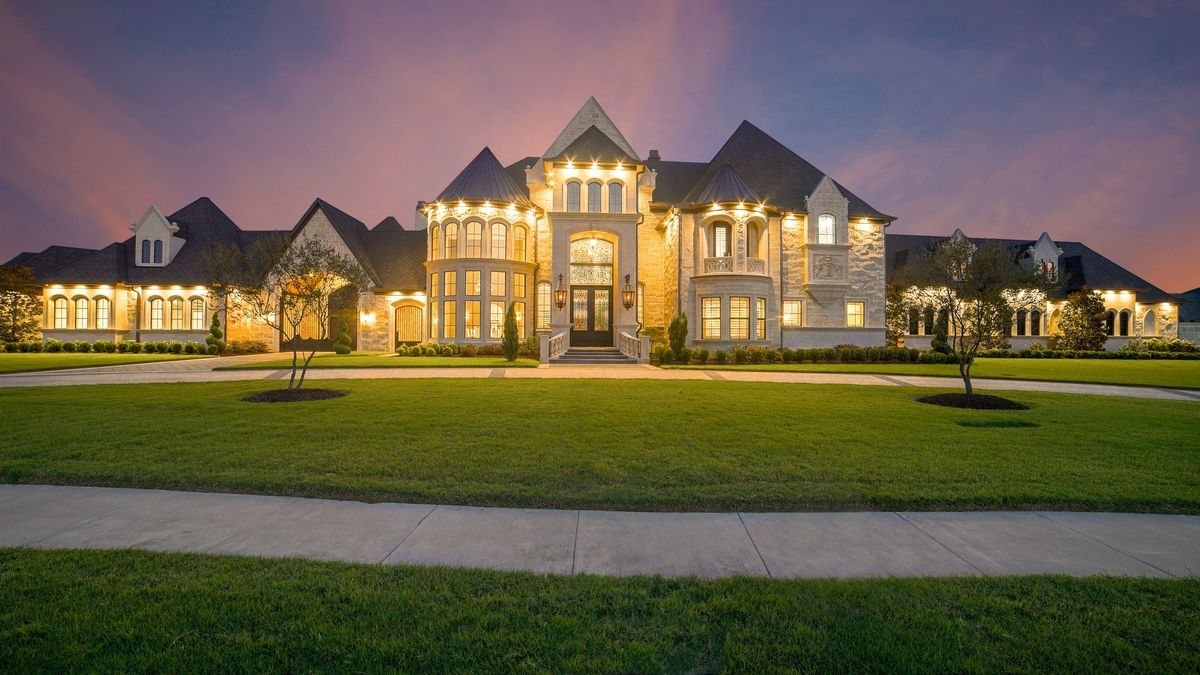

What's new in this version:
* Stacking
* Blending

Models Used:
* XGBoost Regressor
* Light Gradient Boosting Regressor
* Ridge Regressor
* Support Vector Regressor
* Gradient Boosting Regressor 
* ElasticNet Regressor
***


In this kaggle competition, we are going to predict the house prices using XGBRegression Technique. We will also try to climb up in the leaderboard.

> Reference: 

* > [Comprehensive data exploration with Python By Pedro Marcelino](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python/notebook?select=test.csv)

* > [Stacked Regressions By Serigne](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
* > [Ultimate Predictions Guide [v6] By Preston Fan](https://www.kaggle.com/prestonfan/ultimate-predictions-guide-v6)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

#ignoring all the warnings because we don't need them
import warnings
warnings.filterwarnings('ignore')

sb.set()
sb.set_style("white")
%matplotlib inline
rcParams['figure.figsize'] = [9,6]

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

We have successfully imported everything we need to solve this challenge. Now let us get started with importing the data and getting our hands dirty.

In [ ]:
# let us bring our guns
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')

# perform our final prediction on
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

# Save the Id
test_id = test['Id']

In [ ]:
train.head(6)

In [ ]:
# Lets check that test dataset has all the columns in train dataset except SalePrice
diff_train_test = set(train.columns) - set(test.columns)
diff_train_test

In [ ]:
# looking at the decoration of our data
train.columns

As we can see from the output above that the data has several columns which represent different attributes of a house.

So, we have every thing we need about homes to do our magic. Let us proceed further into the depth and see what we can find.

In [ ]:
print((train.shape), (test.shape), '\n')
print("Shape of train.csv: ", train.shape)
print("Shape of test.csv: ", test.shape)

In [ ]:
train.info()

In [ ]:
# missing_values_bool = train.isnull().any()
# display(missing_values_bool[missing_values_bool == True])

missing_values = train.isnull().sum()
display(missing_values[missing_values>0].sort_values(ascending=False).to_frame(name='Missing Values'))

In [ ]:
percent = ((train.isnull().sum()/train.isnull().count()) * 100).sort_values(ascending=True)
percent = percent[percent>0]

plt.xticks(rotation=90); plt.title('Percent Missing Values')
sb.barplot(x=percent.index, y=percent, palette="viridis")

## Analyzing the target variable

In [ ]:
train['SalePrice'].describe()

So, after gaining a more in depth view of Sale Price, we can conclude that:

> *The minimum value is greater than 0, which is a good thing as we have to work less on cleaning the data and replacing the values with mean.*

We can move forward with our project.

In [ ]:
plt.subplots(figsize=(10, 5))
plt.figure(1)
ax = sb.distplot(train['SalePrice'], bins=30, fit=norm, color="mediumslateblue")
ax.set(xlabel='SalePrice', ylabel='Frequency')
plt.xticks(rotation=-45)

plt.subplots(figsize=(10,5))
plt.figure(2)
stats.probplot(train['SalePrice'], plot=plt)

From the above chart, we can clearly see that:
* The Sales Price deviates from Normal Distribution.
* It shows peakedness.
* Its positively skew.

After looking at the skewness of our SalePrice data, let us understand more about its skewness and kurtosis.
But first, we will learn what is this **skewness** and **kurtosis** that we keep talking about?

## Skewness:
Skewness measures the lack of symmetry in our distribution. A distribution could be either positively skew or negatively skew.


Let us find out the skewness and kurtosis of the above distribution.

In [ ]:
sell = train['SalePrice']

print(f"Skewness: {sell.skew()}")
print(f"Kurtosis: {sell.kurt()}")

Let's visualise this data in in *boxenplot(), violinplot() and stripplot()*:

In [ ]:
plt.figure(1); plt.title('Boxen plot of the Sales Prices')
sb.boxenplot(train['SalePrice'],color="mediumslateblue")

plt.figure(2); plt.title('Violin plot of the Sales Prices')
sb.violinplot(train['SalePrice'], color="mediumslateblue")

plt.figure(3); plt.title('Strip plot of the Sales Prices')
sb.stripplot(train['SalePrice'], alpha=0.6, color="mediumslateblue")

In [ ]:
#swarmplot of overall quality
plt.subplots(figsize=(10, 6))
plt.title('Overall Quality of homes')
sb.swarmplot(train['OverallQual'], train['Id'], palette="viridis")

In [ ]:
train['OverallQual'].value_counts()

It can be clearly seen that the rating of 5 is very common in both *'overall quality'*.

We see similar kind of result when we perform this operation on *'overall condition'*.

Now we can move one step and include *Sale Price* in our charts and compare it with *Overall Quality* and *Overall Condition* of the house.

## SalePrice and Overall Quality

In [ ]:
# sb.pairplot(train[features_ver1])

data_seg1 = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)

plt.subplots(figsize=(9,5))
plt.figure(1); plt.title("SalePrice vs Overall Quality")
sb.boxplot(x='OverallQual', y='SalePrice', data=data_seg1, color="mediumslateblue")

plt.subplots(figsize=(9,5))
plt.figure(2); plt.title("SalePrice vs Overall Quality")
sb.lineplot(x='OverallQual', y='SalePrice', data=data_seg1, color="mediumslateblue")

## SalePrice and Overall Condition

In [ ]:
data_seg2 = pd.concat([train['SalePrice'], train['OverallCond']], axis=1)

plt.subplots(figsize=(9,5))
plt.figure(1); plt.title("SalePrice vs Overall Condition")
sb.boxplot(x='OverallCond', y='SalePrice', data=data_seg2, color="mediumslateblue")

plt.subplots(figsize=(9,5))
plt.figure(2); plt.title("SalePrice vs Overall Condition")
sb.lineplot(x='OverallCond', y='SalePrice', data=data_seg2, color="mediumslateblue")

Unlike Overall Quality, Overall Condition represents non-linear graph. Therefore, we can conclude that, Overall Condition doesn't has a high impact on the SalePrice on a higher magnitude and thus we can skip it.
Overall condition is a categorical variable and we will change it later on when we do feature engineering.

## SalePrice and GrLivArea

In [ ]:
data_seg3 = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)

plt.subplots(figsize=(10, 6))
plt.figure(1); plt.title('SalePrice vs Above Ground Living Area')
sb.scatterplot(x='GrLivArea', y='SalePrice', data=data_seg3, alpha=0.8, color="mediumslateblue")

### We have *Outliers* in our data:

From the image above, we can clearly see that two values of 'GrLivArea' are performing very strange as they show to have huge above ground surface area while the SalePrice is considerably low, which is not possible. These values are called **Outliers**. These two points can cause us problems. Hence, we must drop these two values.

Lets remove these outliers for good.

In [ ]:
# drop the outliers
# we drop the rows containing value of GrLivArea greater than 4000 and 
# SalePrice less than 200000
# these are huge outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index)

plt.subplots(figsize=(10,6))
sb.scatterplot(train['GrLivArea'], train['SalePrice'], alpha=0.8, color="mediumslateblue")

Take a look at the code below. This is the center of attraction in above code segment.

> **train[**  (train['GrLivArea'] > 4000)  &  (train['SalePrice'] < 200000)  **]**.index

As we can see from the graph above that we have successfully removed the outliers. This graph looks more acceptable and we have less to worry now. Lets move on to the next variable.

## SalePrice vs Total Basement Area

In [ ]:
plt.subplots(figsize=(10,6))
sb.scatterplot(train['TotalBsmtSF'], train['SalePrice'], alpha=0.8, color="mediumslateblue")

There are no huge outliers in this data. This looks good and thus we can move forward.

## SalePrice vs YearBuilt

In [ ]:
# we change the graph size for this particular graph using subplots unlike rcParams which changes for the entire notebook
plt.subplots(figsize=(20,8))
plt.xticks(rotation=90)
plt.figure(1); plt.title("SalePrice vs YearBuilt")
sb.stripplot(train['YearBuilt'], train['SalePrice'])

plt.subplots(figsize=(20,8))
plt.xticks(rotation=90)
plt.figure(2); plt.title("SalePrice vs YearBuilt")
sb.boxenplot(train['YearBuilt'], train['SalePrice'])

From above graph, we can conclude that 'SalePrice' enjoys company of homes that were recently built. Hence, the prices of newer homes are high when compared to older houses.

## Lets Summarize
From above graphs, we can summarize that:
* SalePrice and OverallQuality have a strong relationship. SalePrice increases with the increase in Overall Quality.
* SalePrice and GrLivArea are linearly related. When above ground living area increases, sale price also increases.
* SalePrice and YearBuilt are related.
* SalePrice and TotBsmtSF are linearly related just as GrLivArea.

### HeatMap
Further, we will see the use of heatmap to find out the relation between all the variables.

# Feature Engineering
We want to analyze all the variables against SalePrice to find out that how much does it effect the SalePrice.

We will perform these operations in order to find out the SalePrice relationship with all the other variables:
* Correlation matrix (using heatmap)
* 'SalePrice' correlation matrix
* Scatter plots between the most correlated variables



* Lets create a correlation matrix using heatmap.

In [ ]:
# this is a really important code section
# look at how we compute the correlation with df.corr() function and then feed it to sb.heatmap()
# play around by tweaking argument values

corrmat = train.corr()
plt.subplots(figsize=(17,17))
plt.title("Correlation Matrix")
# sb.heatmap(corrmat, vmax=0.9, vmin=0.5, square=True, cmap='YlGnBu')
sb.heatmap(corrmat, vmax=0.9, square=True, cmap="Oranges", annot=True, fmt='.1f', linewidth='.1')

There is a large amount of data floating around in the heatmap above. All we have to do is to understand how to interpret it. 

First of all, one thing is clear to us and that is we are only concerned with the target variable i.e. SalePrice and all the variables effecting it on a higher magnitude.

Lets interpret the relation of SalePrice with other variables by ovserving the heatmap. On the left hand side, bottom corner we can see SalePrice (the first row in the vertical column). Here, we are only concerned with that row. So, lets ignore all the other rows. Now, on the extreme right side we can see something like a color palette with different values. It indicates the degree of relation. If the color is very dark e.g. 0.8, it means that the corresponding variable effects SalePrice sharply.

Coming back to the bottom row, we can see that 'OverallQual' has a very dark color and hence it effects the SalePrice directly and so on for other variables.

## SalePrice Correlation Matrix using HeatMap

Now, moving on to the most important step in finding out the relationship of important vaiables with SalePrice.

Let us create a 'SalePrice' correlation matrix using heatmap.

In [ ]:
# we can convert a series object to a dataframe using to_frame() method on the series
imp_ftr = corrmat['SalePrice'].sort_values(ascending=False).head(11).to_frame()

imp_ftr

In [ ]:
# first graph
plt.subplots(figsize=(5,8))
plt.title('SalePrice Correlation Matrix')
sb.heatmap(imp_ftr, vmax=0.9, annot=True, fmt='.2f', cmap="Oranges", linewidth='.1')

In [ ]:
degree_correlation = corrmat['SalePrice'].sort_values(ascending=False)
degree_correlation.to_frame()

In [ ]:
plt.subplots(figsize=(10,12))
plt.title('Correlation with SalePrice')
degree_correlation.plot(kind='barh', color="mediumslateblue")

# Analyzing Most Related Feature Values

Lets find out highly correlated variables (>0.8) as it smells like something unexpected is cooking. You may find out that they are the same things with two different names. Such as YearBuilt and GarageYrBuilt are same as the garage must have been built when the home was built.

In [ ]:
plt.subplots(figsize=(15, 15))
sb.heatmap(corrmat>0.8, annot=True, square=True, cmap="Oranges", linewidth='.1')

From the heatmap above, we can clearly see the highly-correlated features.
* YearBuilt vs GarageYrBlt
* 1stFlrSF vs TotalBsmtSF
* GrLivArea vs TotRmsAbvGrd
* GarageCars vs GarageArea

We know that we have to drop one from each pair. So, we look at the main correlation matrix and find our which is less correlated to 'SalePrice' in the pair of two and we drop that feature.

In [ ]:
# Dropping unwanted features
train.drop(columns=['GarageArea','TotRmsAbvGrd','GarageYrBlt','1stFlrSF'],axis=1,inplace=True) 
test.drop(columns=['GarageArea','TotRmsAbvGrd','GarageYrBlt','1stFlrSF'],axis=1,inplace=True)

Let us look at the data after dropping variables.

In [ ]:
degree_correlation = corrmat['SalePrice'].sort_values(ascending=False)
degree_correlation.to_frame()

## Looking at the Bigger Picture
Finally, we create a scatter plot between SalePrice and most important related variables in order to look at the entire picture.

In [ ]:
numerical_data = train.select_dtypes(exclude=['object']).drop(['SalePrice', 'Id'],axis=1).copy()
categorical_data = train.select_dtypes(include=['object']).columns

In [ ]:
fig = plt.figure(figsize=(17,22))
for i in range(len(numerical_data.columns)):
    fig.add_subplot(9,4,i+1)
    sb.distplot(numerical_data.iloc[:,i].dropna(), hist=False, kde_kws={'bw':0.1}, color='mediumslateblue')
    plt.xlabel(numerical_data.columns[i])
plt.tight_layout()
plt.show()

In [ ]:
cmap = sb.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
fig1 = plt.figure(figsize=(17,22))
for i in range(len(numerical_data.columns)):
    fig1.add_subplot(9, 4, i+1)
    sb.scatterplot(numerical_data.iloc[:, i],train['SalePrice'], palette='spring', marker='+', hue=train['SalePrice'], legend=False)
plt.tight_layout()
plt.show()

In [ ]:
columns = (len(categorical_data)/5)+1

fg, ax = plt.subplots(figsize=(18, 30))

for i, col in enumerate(categorical_data):
    fg.add_subplot(columns, 5, i+1)
    sb.countplot(train[col], palette='spring')
    plt.xlabel(col)
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

## Log Transform on SalePrice
SalePrice is skewed and deviates from Normal Distribution. Let us do a log transform on 'SalePrice'.

We perform this step right before fitting our model and we then reverse it back to normal after we have made our predictions (at the time of submitting SalePrice to competition).

In [ ]:
train['SalePrice'] = np.log1p(train['SalePrice'])

plt.subplots(figsize=(11, 5))
plt.figure(1)
ax = sb.distplot(train['SalePrice'], bins=100, fit=norm, color="mediumslateblue")
ax.set(xlabel='SalePrice', ylabel='Frequency')
plt.xticks(rotation=-45)

plt.subplots(figsize=(10,5))
plt.figure(2)
stats.probplot(train['SalePrice'], plot=plt)

> SalePrice now looks normally distributed and does not show skewness. And yes, it does puts a smile on my face!

## Disguise

Few categorical values are disguised as numerical values. We will transform these ASAP!!

In [ ]:
#MSSubClass=The building class
train['MSSubClass'] = train['MSSubClass'].apply(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
train['OverallCond'] = train['OverallCond'].astype(str)
test['OverallCond'] = test['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
train['YrSold'] = train['YrSold'].astype(str)
test['YrSold'] = test['YrSold'].astype(str)

train['MoSold'] = train['MoSold'].astype(str)
test['MoSold'] = test['MoSold'].astype(str)

# Handling Missing Values

Let us first find out the columns which have missing values. Further, we will learn to handle all these missing values.

.


> Pay attention to the code below to understand how we can find the names of columns which have missing values.

In [ ]:
# Find columns with missing values
cols_with_missing = [col for col in train.columns if train[col].isnull().any()]
cols_with_missing

**Percent of Missing Values**

Let us find out the total number and percent of missing values in each of the column.

In [ ]:
# Finding total number of missing values in each column
total_missing = train.isnull().sum().sort_values(ascending=False)
total_missing = total_missing[total_missing>0]

percent = ((train.isnull().sum()/train.isnull().count()) * 100).sort_values(ascending=False)
percent = percent[percent>0]

data_missing = pd.concat([total_missing, percent], axis=1, keys=['Total', 'Percent'])
data_missing

As we can see that there are a total of 18 variables. PoolQC (Pool Quality) has approximately 99 percent of data missing. This is alarming for a lot of people that how can it be possible. And if it has so much data missing then should we drop the column all together?

The answer is no!

If we look at the 'data_description.txt', we can see that a 'NA' in PoolQC means No Pool and it makes sense that a lot of homes do not have pool. We can fill all the cells containing 'NA' with 'None', which means the house does not have a pool.

We can similarly transform many categorical columns.

## Imputing Missing Values

Lets find out all the categorical columns in our data.

In [ ]:
object_cols = [col for col in train.columns if train[col].dtype == "object"]
object_cols

In [ ]:
# Get number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: train[col].nunique(), object_cols))
d = dict(zip(object_cols, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

In [ ]:
for df in [train, test]:
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                  'BsmtFinType2', 'Neighborhood', 'BldgType', 'HouseStyle', 'MasVnrType', 'FireplaceQu', 'Fence', 'PoolQC', 'MiscFeature', 'Alley'):
        df[col] = df[col].fillna('None')

'MasVnrArea' is categorical in the data but it shouldn't be. Its should be of numerical data type. Thats why we fill the missing values with 0 and later on we will convert it to int data type.

In [ ]:
train['MasVnrArea'] = train['MasVnrArea'].fillna(0)
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)

In [ ]:
# Check for missing values

missing = train.isnull().sum().sort_values(ascending=False)
missing = missing[missing>0]
missing

In [ ]:
train['Electrical'].describe()

In [ ]:
train['Electrical'].mode()[0]

Since, Electrical has only one missing value and 'SBrkr' is the most frequent value. We can fill it with that.

In [ ]:
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])
test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode()[0])

Now, lets handle '**LotFrontage**' which has 259 missing values.

Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

In [ ]:
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))
test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [ ]:
# Check for missing values

missing = train.isnull().sum().sort_values(ascending=False)
missing = missing[missing>0]
missing

There are no more missing values in our 'train' data. It is a moment of enjoyment and happiness. But, before all that let's check out the test data real quick for missing values.

### Additional Missing values in test data

In [ ]:
# Categorical missing values in test data
missing = test.select_dtypes(include='object').isnull().sum().sort_values(ascending=False)
missing = missing[missing>0]
missing

In [ ]:
# Numerical missing values in test data
missing = test.select_dtypes(exclude='object').isnull().sum().sort_values(ascending=False)
missing[missing>0]

Let's tackle all the missing **categorical** test data.

We will handle the first missing variable which is 'MSZoning'.

MSZoning means the general zoning classification: Unique values of MSZoning are:

* 'A' for Agriculture
* 'C' Commercial
* 'FV' Floating Village Residential
* 'I' Industrial
* 'RH' Residential High Density
* 'RL' Residential Low Density
* 'RP' Residential Low Density Park
* 'RM' Residential Medium Density

Clearly this feature is correlated to MSSubClass, which is the building class, so we fill in the median based on MSSubClass

In [ ]:
# Handling MSZoning
train['MSZoning'] = train.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
test['MSZoning'] = test.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [ ]:
display(test['Utilities'].describe())
display(train['Utilities'].describe())

After careful examination of 'Utilities' variable we can drop it. We can clearly see that in the test dataset there is only one unique value in the data and two in training set. This will not add any importance to our dataset. 

So, we simply throw it away.

In [ ]:
test = test.drop(['Utilities'], axis=1)
train = train.drop(['Utilities'], axis=1)

In [ ]:
for df in [train, test]:
    for col in ('Functional', 'SaleType', 'Exterior2nd', 'Exterior1st', 'KitchenQual'):
        df[col] = df[col].fillna(df[col].mode()[0])

In [ ]:
# Categorical missing values in test data
missing = test.select_dtypes(include='object').isnull().sum().sort_values(ascending=False)
missing = missing[missing>0]
missing

We have successfully addressed all the categorical missing values. Now we will move on to **numerical** missing values.

In [ ]:
for df in [train, test]:
    for col in ('MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'TotalBsmtSF',
               'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1'):
        df[col] = df[col].fillna(0)

In [ ]:
# Numerical missing values in test data
missing = test.select_dtypes(exclude='object').isnull().sum().sort_values(ascending=False)
missing[missing>0]

Alright, at this point we have eliminated all the missing values from our data.

In [ ]:
train.shape, test.shape

# Extra Feature Engineering

Now, we are going to create some variables in our train and test data which we think are important in training our model and add value to the overall data.

In [ ]:
train.head(10)

### Lets look at all the **Surface Area** variables.

In [ ]:
sf = [col for col in train.columns if 'SF' in col]
sf

### Creating a '*TotalSF*' variable from 'TotalBsmtSF' and '2ndFlrSF'.

In [ ]:
train['TotalSF'] = train['TotalBsmtSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['2ndFlrSF']

In [ ]:
train[['TotalBsmtSF', '2ndFlrSF', 'TotalSF']].head()

In [ ]:
plt.subplots(figsize=(10, 7))
sb.scatterplot(x=train['TotalSF'], y=train['SalePrice'], color="mediumslateblue")

We have successfully created an entire new variable in our train and test dataset. How about that?

Lets see if we can add some more variables which can add value to our dataset.

## The importance of 'Total'
Similarly, we can create different features just like 'TotalSF' containing different useful information.

Lets check them out.

**Bath**

In [ ]:
bath = [col for col in train.columns if 'Bath' in col]
bath

In [ ]:
train['TotalBath'] = train['BsmtFullBath'] + train['BsmtHalfBath'] + train['FullBath'] + train['HalfBath']
test['TotalBath'] = test['BsmtFullBath'] + test['BsmtHalfBath'] + test['FullBath'] + test['HalfBath']

In [ ]:
train[['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotalBath']].head()

In [ ]:
plt.subplots(figsize=(10, 7))
sb.boxenplot(x=train['TotalBath'], y=train['SalePrice'], color="mediumslateblue")

**Porch**

In [ ]:
porch = [col for col in train.columns if 'Porch' in col]
porch

In [ ]:
train['PorchSF'] = train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch'] + train['WoodDeckSF']
test['PorchSF'] = test['OpenPorchSF'] + test['EnclosedPorch'] + test['3SsnPorch'] + test['ScreenPorch'] + test['WoodDeckSF']

In [ ]:
train[['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF', 'PorchSF']].head()

In [ ]:
plt.subplots(figsize=(10, 7))
sb.scatterplot(x=train['PorchSF'], y=train['SalePrice'], color="mediumslateblue")

## The house has it or not?
We can create a new variable 'HasBsmt'. It will specify that if a house has a basement of not.

Similarly, we can create different variables starting with 'Has...'. It will specify that if a house has a particular feature or not. These variables will make the dataset more clear for the buyers.

In [ ]:
pool = [col for col in train.columns if 'Pool' in col]
pool

In [ ]:
# train data
train['HasBsmt'] = train['TotalBsmtSF'].apply(lambda x: 1 if x>0 else 0)
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x>0 else 0)
train['Has2ndFlr'] = train['2ndFlrSF'].apply(lambda x: 1 if x>0 else 0)
train['HasFirePlace'] = train['Fireplaces'].apply(lambda x: 1 if x>0 else 0)
train['HasGarage'] = train['GarageCars'].apply(lambda x: 1 if x>0 else 0)

# test data
test['HasBsmt'] = test['TotalBsmtSF'].apply(lambda x: 1 if x>0 else 0)
test['HasPool'] = test['PoolArea'].apply(lambda x: 1 if x>0 else 0)
test['Has2ndFlr'] = test['2ndFlrSF'].apply(lambda x: 1 if x>0 else 0)
test['HasFirePlace'] = test['Fireplaces'].apply(lambda x: 1 if x>0 else 0)
test['HasGarage'] = test['GarageCars'].apply(lambda x: 1 if x>0 else 0)

In [ ]:
train[['HasBsmt', 'HasPool', 'Has2ndFlr', 'HasFirePlace', 'HasGarage']].head()

In [ ]:
plt.figure(1)
sb.boxenplot(train['HasGarage'], train['SalePrice'], color="mediumslateblue")

plt.figure(2)
sb.boxenplot(train['HasBsmt'], train['SalePrice'], color="mediumslateblue")

plt.figure(3)
sb.boxenplot(train['HasPool'], train['SalePrice'], color="mediumslateblue")

plt.figure(4)
sb.boxenplot(train['Has2ndFlr'], train['SalePrice'], color="mediumslateblue")

plt.figure(5)
sb.boxenplot(train['HasFirePlace'], train['SalePrice'], color="mediumslateblue")

In [ ]:
print(train.shape, test.shape)

### A spy in disguise

Lets convert MasVnrArea from float to int

In [ ]:
train['MasVnrArea'].head()

In [ ]:
train['MasVnrArea'] = train['MasVnrArea'].astype(int)
test['MasVnrArea'] = test['MasVnrArea'].astype(int)

In [ ]:
train['MasVnrArea'].head()

In [ ]:
plt.subplots(figsize=(10, 7))
sb.scatterplot(train['MasVnrArea'], train['SalePrice'], color="mediumslateblue")

# Label Encoding (Manual)

Some categorical variables may contain information in their ordering set and hence we should apply LabelEncoding instead of OneHotEncoding on these variables.

In [ ]:
# Import library
from sklearn.preprocessing import LabelEncoder

label_enc_variables = ['FireplaceQu', 'LotShape', 'OverallCond', 'ExterQual',
                       'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                       'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'GarageFinish', 'GarageQual',
                       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']


# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in label_enc_variables:
    train[col] = label_encoder.fit_transform(train[col])
    test[col] = label_encoder.transform(test[col])

In [ ]:
print(train.shape, test.shape)



# Modelling

After cleaning up of the data and transforming it. We are ready with our data and we can call in our models now to perform the cool stuff.

In [ ]:
# Perform train test split on this data

X = train.drop(['SalePrice'], axis=1)
y = train['SalePrice']

## Final Filling of Missing Data (tying up loose ends)

Filling missing numerical values with 0 and categorical values with 'None'.

In [ ]:
# Filling numerical columns
num_cols = [col for col in X.columns if X[col].dtype!='object']
X.update(X[num_cols].fillna(0))
test.update(test[num_cols].fillna(0))

# Filling categorical columns
cat_cols = [col for col in X.columns if X[col].dtype=='object']
X.update(X[cat_cols].fillna('None'))
test.update(test[cat_cols].fillna('None'))

In [ ]:
print(X.shape, test.shape)

### Importing libraries

In [ ]:
# Importing our libraries

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Added in version 7 of this notebook
from sklearn.model_selection import GridSearchCV
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge, RidgeCV, ElasticNetCV
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=2)

Now, we will only keep all the categorical columns which has a cardinality of less than 30. We do this because of OneHotEncoding as we would get a lot of columns. 

In [ ]:
numerical_cols = [col for col in X_train.columns
                  if X_train[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']]

categorical_cols= [col for col in X_train.columns
                   if X_train[col].nunique()<=30 and X_train[col].dtype=='object']

final_cols = numerical_cols + categorical_cols
X_train = X_train[final_cols].copy()
X_valid = X_valid[final_cols].copy()

test = test[final_cols].copy()

## One-Hot Encoding
We use pandas for one-hot encoding to shorten our code

In [ ]:
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
test = pd.get_dummies(test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, test = X_train.align(test, join='left', axis=1)

In [ ]:
print("X_train Shape", X_train.shape)
print("X_valid Shape", X_valid.shape)
print("test shape", test.shape)

### Reverse log transform on SalePrice

In [ ]:
# Reversing log transform on y ('SalePrice')
def rev_y(trans_y):
    return np.expm1(trans_y)

## Parameter Tuning (XGBoost)

We right our wrongs, move forward and repeat this process again and again.

In [ ]:
estimators = [2000, 2500, 3000, 3500]
for n in estimators:
    my_dict = dict()
    model = XGBRegressor(n_estimators=n, learning_rate=0.01, colsample_bytree=0.45, max_depth=3)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    mae = mean_absolute_error(rev_y(preds), rev_y(y_valid))
    my_dict[f"n_est {n}"] = mae
    print(my_dict)

From above output, we can conclude that n_estimators of ~2500 gives much better result with a learning rate of 0.02.

So, we drop other values.

In [ ]:
my_dict = dict()
n=3500
model = XGBRegressor(n_estimators=n, learning_rate=0.01, colsample_bytree=0.45, max_depth=3,
                     gamma=0, subsample=0.4, reg_alpha=0, reg_lambda=1, objective='reg:squarederror')
    
model.fit(X_train, y_train)
preds = model.predict(X_valid)
mae = mean_absolute_error(rev_y(preds), rev_y(y_valid))
my_dict[f"n_est {n}"] = mae
print(my_dict)

# Creating Models

I thought of stacking different models for prediction after version 6.

So, If you only want to use XGBoost Regressor you can use it. The code above provides with the best parameters for XGBoost.

If you want to improve your model score, follow along. We will have fun with this one!

In [ ]:
# Version 7
n = 3500
my_dict = dict()

# XGBoost Regressor
xgb = XGBRegressor(n_estimators=n,
                   learning_rate=0.01,
                   colsample_bytree=0.45,
                   max_depth=3,
                   gamma=0,
                   subsample=0.4,
                   reg_alpha=0,
                   reg_lambda=1,
                   objective='reg:squarederror')

# Light Gradient Boosting Regressor
lgb = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=n,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas))

# ElasticNet Regressor
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, l1_ratio=e_l1ratio))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=n,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)

# Stacking models
stack = StackingCVRegressor(regressors=(ridge, gbr, xgb, elasticnet, svr, lgb),
                                meta_regressor=xgb,
                                use_features_in_secondary=True)

## Cross-Validation Scores

In [ ]:
Scores = {}

In [ ]:
# Function for checking Cross-val scores                              
def rmse(model, X, y):
    scores = np.sqrt(-1 * cross_val_score(model, X, y,
                        cv=10, 
                        scoring='neg_mean_squared_error'))
    return scores

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
# Cross-val scores                              
scores = rmse(xgb, X_train, y_train)
print("XGBoost Regressor\n")
print("Root Mean Square Error (RMSE)", str(scores.mean()))
print("Error Standard Deviation", str(scores.std()))
Scores['XGB'] = scores.mean()

In [ ]:
scores = rmse(lgb, X_train, y_train)
print("Light Gradient Boosting Regressor\n")
print("Root Mean Square Error (RMSE)", str(scores.mean()))
print("Error Standard Deviation", str(scores.std()))
Scores['LGB'] = scores.mean()

In [ ]:
scores = rmse(ridge, X_train, y_train)
print("Ridge Regressor\n")
print("Root Mean Square Error (RMSE)", str(scores.mean()))
print("Error Standard Deviation", str(scores.std()))
Scores['Ridge'] = scores.mean()

In [ ]:
scores = rmse(svr, X_train, y_train)
print("Support Vector Regressor\n")
print("Root Mean Square Error (RMSE)", str(scores.mean()))
print("Error Standard Deviation", str(scores.std()))
Scores['SVR'] = scores.mean()

In [ ]:
scores = rmse(gbr, X_train, y_train)
print("Gradient Boosting Regressor\n")
print("Root Mean Square Error (RMSE)", str(scores.mean()))
print("Error Standard Deviation", str(scores.std()))
Scores['GBR'] = scores.mean()

In [ ]:
scores = rmse(elasticnet, X_train, y_train)
print("ElasticNet Regressor\n")
print("Root Mean Square Error (RMSE)", str(scores.mean()))
print("Error Standard Deviation", str(scores.std()))
Scores['ElasticNet'] = scores.mean()

## Fit the models

In [ ]:
xgb.fit(X_train, y_train)

In [ ]:
lgb.fit(X_train, y_train)

In [ ]:
ridge.fit(X_train, y_train)

In [ ]:
svr.fit(X_train, y_train)

In [ ]:
gbr.fit(X_train, y_train)

In [ ]:
elasticnet.fit(X_train, y_train)

In [ ]:
stack.fit(np.array(X_train), np.array(y_train))

# Blending

In [ ]:
def blended_predictions(X):
    return ((0.2 * ridge.predict(X)) + \
            (0.2 * elasticnet.predict(X)) + \
            (0.05 * svr.predict(X)) + \
            (0.1 * gbr.predict(X)) + \
            (0.1 * xgb.predict(X)) + \
            (0.1 * lgb.predict(X)) + \
           (0.25 * stack.predict(np.array(X))))

In [ ]:
X_valid = X_valid.fillna(0)
test = test.fillna(0)

In [ ]:
blended_score = rmsle(y_valid, blended_predictions(X_valid))

Scores['Blended'] = blended_score
blended_score

In [ ]:
plt.subplots(figsize=(15, 7));plt.title("Scores of different models") 
plt.xticks(rotation=45)
sb.pointplot(x=list(Scores.keys()), y=[score for score in Scores.values()], markers=['o'], linestyles=['-'], color="mediumslateblue")

# Final Model and Submission

In [ ]:
# Read in sample_submission dataframe
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.shape

In [ ]:
# Append predictions from blended models
submission.iloc[:,1] = np.floor(rev_y(blended_predictions(test)))

In [ ]:
# Brutal approach to deal with outliers
q1 = submission['SalePrice'].quantile(0.0045)
q2 = submission['SalePrice'].quantile(0.99)

submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)

### Submission

In [ ]:
submission['SalePrice'] *= 1.001619
submission.to_csv("new_submission.csv", index=False)

## If you are here, then please UpVote this notebook. It would only take a second and would mean a lot to me!!
## Thank You
### Have a wonderful day!